In [1]:
%tensorflow_version 2.x
"""
Neural Network Sprint - learning to use tensorflow and keras to learn a curve
Semi-systematically investigating what makes the networks work the way they do

.. codeauthor:: Alex Lyttle
.. codeauthor:: Lindsey Carboneau
"""
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Make sure to import the `keras` package from tensorflow - there's a different version that is older and won't work later, and it's the default if you only use `import keras` or `from keras import _package`

In [2]:
# basic imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
# special imports for messing with the architecture by hand
from tensorflow.keras import layers
# probably could be ommitted
import time
import os

In [3]:
import pandas as pd
import pymc3 as pm

## Making sure I can properly access the data
Let's try to load it in "locally" from GDrive attached to my colab session

In [ ]:
os.path.isfile('./drive/My Drive/this/grid_0_0.csv')

False

### So now I'll try to pull in some data - this was taken from the [Interstellar](https://github.com/alexlyttle/Interstellar/tree/master/Small_grid) Small-grid folder  
  
My goal is to train a network and model a star; but from a glance at the `mesa_grid` folder, I don't think I'm ready to deal with those huge csv files. In the other notebooks that use the grids, generally they (re: Guy, Alex) pull in data using `pandas` and `interstellar.Data` - I've never used `pandas` before (except with Alex at the next desk telling me how, and only on a lightcurve?) and I want to understand what the "shape" of the data is before I start using packages (like `interstellar`) to deal with it for me

When I've used data in the past, I've pulled it out of CSV or FITS and stuffed it into a numpy array - because I usually only deal with data in the form of cadence frames for photometry or the resulting lightcurves for corrections/analysis. On some level I don't feel comfortable with multidimensional data 

That said, I think maybe I'll pull in the data here with `pandas` following the example from Guy's [small-grid](https://github.com/alexlyttle/Interstellar/blob/master/Small_grid/Train%20small%20grid.ipynb) notebook to start. I think the step between this and the full grid is to stuff the data from each CSV into a dataframe of some sort; and the step before that is to read the `pandas` (and `interstellar.Data`) documentation to figure out what that actually looks like.  
This might need to look like the diagram for FITS from the old notebook

In [ ]:
grid = pd.read_csv('./drive/My Drive/this/grid_0_0.csv')
sample = grid.sample(frac=1) # this is just the whole thing; <1 is a % of len, >1 is * len (i.e., 2 means 'full sample twice')
sample.head() # returns the first n rows; default 5 <-- so the `sample` is randomly ordering the rows?


,Unnamed: 0,model_number,star_mass,star_age,star_feh,star_MLT,star_fov,effective_T,luminosity,radius,log_g,surface_h1,surface_he4,center_h1,center_he4,log_center_T,log_center_Rho,he_core_mass,delta_nu,delta_Pg,nu_max,nu_0_10,nu_0_11,nu_0_12,nu_0_13,nu_0_14,nu_0_15
2088,388,389,0.9,0.000050,0.0,1.9,0.018,4375.839172,12.714117,6.212684,2.805573,0.712959,0.270686,0.712959,0.270686,6.060359,-1.450450,0.0,8.272540,0.0,82.787168,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
39679,565,566,2.0,0.000186,0.0,1.9,0.018,4914.339836,18.388458,5.923810,3.193717,0.712959,0.270686,0.712959,0.270686,6.415339,-1.066701,0.0,13.244935,0.0,190.943476,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
24498,684,685,1.5,0.000829,0.0,1.9,0.018,4864.393080,4.387185,2.953211,3.673392,0.712959,0.270686,0.712959,0.270686,6.587351,-0.286570,0.0,32.586702,0.0,579.158757,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
26348,834,835,1.6,0.006131,0.0,1.9,0.018,5553.278418,3.126637,1.912928,4.078612,0.712959,0.270686,0.712957,0.270686,6.910067,1.099612,0.0,64.557769,0.0,1378.026662,734.004972,798.138986,862.02667,926.487667,990.680801,1054.168556
25731,217,218,1.6,0.000002,0.0,1.9,0.018,4128.233497,192.844400,27.185282,1.773342,0.712959,0.270686,0.712959,0.270686,5.682146,-3.075796,0.0,1.205024,0.0,7.913704,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


## Next is to decide inputs and outputs  
Ideally this is probably something like


### Inputs:  
Age, Mass, Metalicity, MLT, Helium, ... (more properly: fractional age, initial Fe/H, initial Y, etc.)  

  <br> 

### Outputs: 
Luminosity, Effective Temperature, $\Delta\nu$

for this practice, sticking with mass & age in, Teff & luminosity out
(using the same input formatting as from Guy's example - see link above)

In [ ]:
# QSTN: does 'star_feh' need to be ^10? are any values in this grid non-zero? see below, I need to look up the documentation
x_cols = ['star_age', 'star_mass'] # not sure if this grid actually has all the inputs I'm ideally looking for
# TODO: check emails from Alex re: descriptions of what each grid actually is, although this one was always meant as a small sample?
y_cols = ['luminosity', 'effective_T']
x = np.log10(sample[x_cols].values).astype('float32')
# not sure how much this not being fractional age is going to matter right now... 
y = np.log10(sample[y_cols].values).astype('float32')

Should plot a small sample of the grid to make sure we know what it is that's actually being looked at

Text(0, 0.5, 'luminosity')

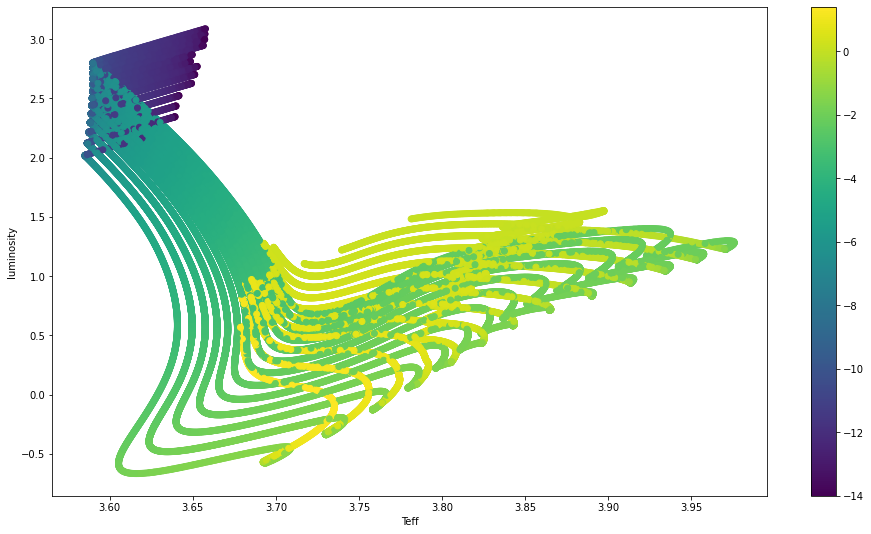

In [ ]:
fig, ax = plt.subplots(figsize=[16,9])
cs = ax.scatter(y[:, 1], y[:, 0], c=x[:, 0])
fig.colorbar(cs)
ax.set_xlabel('Teff') 
ax.set_ylabel('luminosity') 
# luminosity codes some info on radius, but this is one place where I need to convince myself I understand an evolutionary track plot

## Setting up parameters for the shape and behavior of the neural net:

> `architecture` : [_# of nodes/layer_ ] * (_# of layers_)

You can have layers of different sizes, and layers that start with new inputs that are not included in previous layers, as well as layers that output solutions *and* provide input for new layers

> `activation` : _name of activation function_

These are usually built in functions, although you can also define your own. Common options are `elu`, `relu`, `sigmoid`, `tanh`, etc.

Documentation: https://keras.io/activations/ 




In [ ]:
start = time.clock()
print(time.time())

1595944916.7947145


In [ ]:
architecture = [64] * 2
activation = 'relu' 
#for now

This bit actually builds up the 'physical' (in memory?) model of the network - inputs are hooked up to the first layer, hidden layers are created and hooked to the layer before them linked-list style, and finally the output layer caps the end.

Naming things isn't strictly required, but it's a good practice.

A lot of this is automatically handled by codes that set up their own layers; we're getting our hands dirty here by doing it ourselves 

In [ ]:
# Guy's example has a little flag to flip, so that you don't have to train the network everytime if you just want to play around
# reset = True # everything else goes in an "if reset; else" statement

inputs = layers.Input(shape=(len(x_cols),), name='inputs')
hidden = layers.Dense(architecture[0], activation=activation)(inputs)

for a in architecture[1:]:
  hidden = layers.Dense(a, activation=activation)(hidden)

outputs = layers.Dense(len(y_cols), name='outputs')(hidden)

model = keras.Model(inputs=inputs, outputs=outputs, name='test_grid_model')

In [ ]:
model.summary()

Model: "test_grid_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
outputs (Dense)              (None, 2)                 130       
Total params: 4,482
Trainable params: 4,482
Non-trainable params: 0
_________________________________________________________________


Now we decide 'how' the net will learn, by giving it:

a loss function (https://keras.io/losses/)

a learning rate (see optimizers)

an optimization algorithm (https://keras.io/optimizers/)

and then defining what metrics we want to see in the output (https://keras.io/metrics/)

In [ ]:
loss = 'mean_absolute_error' # maybe 'mean_squared_error' ?
learning_rate = 0.01 
# note that depending on the optimizer, we don't use this rate
optimizer = keras.optimizers.Nadam()
metrics = ['mae', 'mse']

This bit just sticks the controls we just decided onto the model itself and compiles it to run

In [ ]:
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics
)

Finally we decide how long the net will learn:

The batch size is the number of rows in the training data to use before the weights are updated. Small batch sizes can yield good results early on in training.

The epochs are the number of times the whole dataset is run through during training.

The validation split is the amount of data reserved for the test stage during training. It's important to shuffle the input data before training so that this is random. In our case, x is chosen at random anyway.

In [ ]:
batch_size = int(len(grid))
epochs = 5000
validation_split = 0.2

Now we can finally train our net, and see how well it learns. By assigning it to `history`, we can plot how well we're doing over time

In [ ]:
history = model.fit(x, y,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=validation_split,
                    verbose=0)
model.save('./drive/My Drive/this/test_grid_model.h5')

In [ ]:
runningtime = (time.clock() - start) / 60
runningtime

3.963762416666667

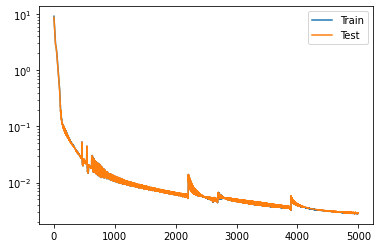

In [ ]:
plt.plot(history.history['mse'], label='Train')
plt.plot(history.history['val_mse'], label='Test')
plt.yscale('log')
plt.legend()

In [ ]:
x_val = np.log10(sample[x_cols].values).astype('float32')
y_val = np.log10(sample[y_cols].values).astype('float32')

In [ ]:
validation = {key: value for key, value in zip(['loss', *metrics], model.evaluate(x_val, y_val, verbose=0))}
validation

{'loss': 0.0334228090941906,
 'mae': 0.0334228090941906,
 'mse': 0.0028351261280477047}

In [ ]:
y_pred = model.predict(x_val)

Text(0.5, 1.0, 'NN output')

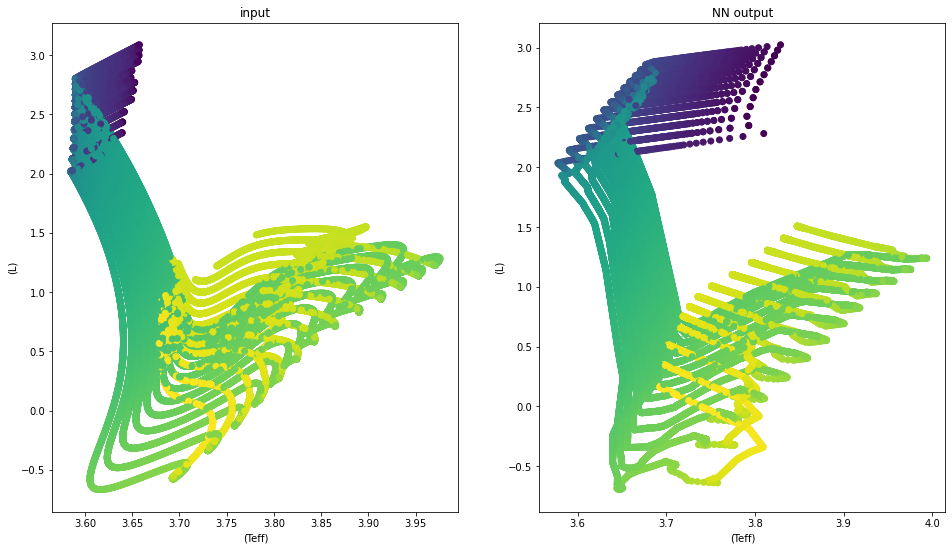

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=[16,9])
ax[0].scatter(y_val[:, 1], y_val[:, 0], c=x_val[:, 0])
ax[1].scatter(y_pred[:, 1], y_pred[:, 0], c=x_val[:, 0])

[n.set_xlabel('(Teff)') for n in ax]
[n.set_ylabel('(L)') for n in ax]
ax[0].set_title('input')
ax[1].set_title('NN output')
#fig.savefig('./drive/My Drive/this/grid_0_v0.png')